# Download and Mount MIT-BIH Data

In [1]:
import os
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

# Set target project/data directory
PROJECT_DIR = '/content/drive/MyDrive/ecg-cnn-classifier'
DATA_DIR = os.path.join(PROJECT_DIR, 'MIT-BIH')
DATA_ZIP = os.path.join(PROJECT_DIR, 'heartbeat.zip')

# Create folder if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

# Move kaggle.json to proper location with correct permissions
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/secrets/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using Kaggle CLI, only if it's not already downloaded
if not os.path.exists(DATA_ZIP):
    print("Downloading from Kaggle...")
    !kaggle datasets download -d shayanfazeli/heartbeat -p "$PROJECT_DIR"
else:
    print("Dataset already downloaded.")

# Unzip into DATA_DIR if not already extracted
if not os.path.exists(os.path.join(DATA_DIR, 'mitbih_train.csv')):
    print("Unzipping dataset...")
    !unzip -q "$DATA_ZIP" -d "$DATA_DIR"
else:
    print("Dataset already unzipped.")

# Confirm contents
!ls "$DATA_DIR"


Mounted at /content/drive
Dataset already downloaded.
Dataset already unzipped.
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import Data

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

train_df = pd.read_csv(f"{DATA_DIR}/mitbih_train.csv", header=None)
test_df = pd.read_csv(f"{DATA_DIR}/mitbih_test.csv", header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values.astype(int)

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values.astype(int)

X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / X_train.std(axis=1, keepdims=True)
X_test = (X_test - X_test.mean(axis=1, keepdims=True)) / X_test.std(axis=1, keepdims=True)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (87554, 187) Test: (21892, 187)


# Define Classes

In [ ]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.0):
        super().__init__()
        self.downsample = downsample or (in_channels != out_channels)

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.skip = nn.Sequential()
        if self.downsample:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += identity
        return self.relu(out)


In [5]:
class DeepECGResNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock1D(1, 32)
        self.pool1 = nn.MaxPool1d(2)  # 187 → ~93

        self.block2 = ResidualBlock1D(32, 64)
        self.pool2 = nn.MaxPool1d(2)  # ~93 → ~46

        self.block3 = ResidualBlock1D(64, 128)
        self.pool3 = nn.MaxPool1d(2)  # ~46 → ~23

        self.block4 = ResidualBlock1D(128, 128)
        self.pool4 = nn.AdaptiveAvgPool1d(1)  # output shape: [B, 128, 1]

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        x = self.pool1(self.block1(x))
        x = self.pool2(self.block2(x))
        x = self.pool3(self.block3(x))
        x = self.pool4(self.block4(x))  # shape: [B, 128, 1]
        x = self.flatten(x)
        return self.fc(x)


In [7]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.counter = 0
        self.best_loss = None
        self.best_model = None
        self.should_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

    def load_best_model(self, model):
        if self.restore_best and self.best_model is not None:
            model.load_state_dict(self.best_model)


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=alpha)

    def forward(self, input, target):
        logp = torch.nn.functional.log_softmax(input, dim=1)
        ce_loss = self.ce(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


In [9]:
class ECGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.add_noise(x)
        return x, self.y[idx]

    def add_noise(self, x, noise_factor=0.01):
        noise = torch.randn_like(x) * noise_factor
        return x + noise


# Hyperparameters

In [10]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001

# Datasets
train_dataset = ECGDataset(X_train, y_train, augment=True)
test_dataset = ECGDataset(X_test, y_test, augment=False)

# Weighted Sampler for Class Imbalance
class_sample_count = np.bincount(y_train)
sampling_weights = 1.0 / class_sample_count
sample_weights = torch.tensor(sampling_weights[y_train], dtype=torch.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# GPU for speed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class weights for focal loss
class_counts = Counter(y_train)
total = sum(class_counts.values())
focal_weights = [total / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(focal_weights, dtype=torch.float32).to(device)

# Model, Loss, Optimizer, Early Stopping
model = DeepECGResNet1D().to(device)

loss_fn = FocalLoss(alpha=None, gamma=2)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

early_stopper = EarlyStopping(patience=5, min_delta=0.0001)

# Track losses and epochs
train_losses = []
val_losses = []
epochs = []



Using device: cpu


# Training Loop

In [12]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation loss ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output = model(X_val)
            loss = loss_fn(output, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    # Save model if this is the best so far
    if epoch == 0 or avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✅ Saved new best model at epoch {epoch+1} (val loss: {avg_val_loss:.4f})")


    epochs.append(epoch + 1)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")
    early_stopper(avg_val_loss, model)

    if early_stopper.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step(avg_val_loss)


✅ Saved new best model at epoch 1 (val loss: 2.9314)
Epoch 1: Train Loss = 0.0412 | Val Loss = 2.9314
✅ Saved new best model at epoch 2 (val loss: 0.0114)
Epoch 2: Train Loss = 0.0131 | Val Loss = 0.0114
Epoch 3: Train Loss = 0.0029 | Val Loss = 5.6383
Epoch 4: Train Loss = 0.0194 | Val Loss = 0.1641
Epoch 5: Train Loss = 0.0035 | Val Loss = 1.4626
Epoch 6: Train Loss = 0.0099 | Val Loss = 0.0143
✅ Saved new best model at epoch 7 (val loss: 0.0101)
Epoch 7: Train Loss = 0.0021 | Val Loss = 0.0101
✅ Saved new best model at epoch 8 (val loss: 0.0052)
Epoch 8: Train Loss = 0.0009 | Val Loss = 0.0052
Epoch 9: Train Loss = 0.0007 | Val Loss = 0.0058
Epoch 10: Train Loss = 0.0005 | Val Loss = 0.0055
Epoch 11: Train Loss = 0.0008 | Val Loss = 0.1395
Epoch 12: Train Loss = 0.0140 | Val Loss = 2.6104
Epoch 13: Train Loss = 0.0127 | Val Loss = 0.0094
Early stopping at epoch 13


# Evaluation

In [13]:
# Load best model and save
model.load_state_dict(torch.load('best_model.pt'))
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': avg_val_loss,
}, 'checkpoint.pt')

model.eval()

correct = total = 0
test_loss = 0.0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        test_loss += loss.item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total

print(f"Final Test Loss: {avg_test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Loss: 0.0052
Final Test Accuracy: 94.91%


In [14]:
# Get all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Print detailed report
print(classification_report(all_labels, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.9955    0.9473    0.9708     18118
           1     0.4464    0.8759    0.5914       556
           2     0.8867    0.9517    0.9181      1448
           3     0.4573    0.9259    0.6122       162
           4     0.9535    0.9944    0.9735      1608

    accuracy                         0.9491     21892
   macro avg     0.7479    0.9390    0.8132     21892
weighted avg     0.9673    0.9491    0.9552     21892



# Visualization

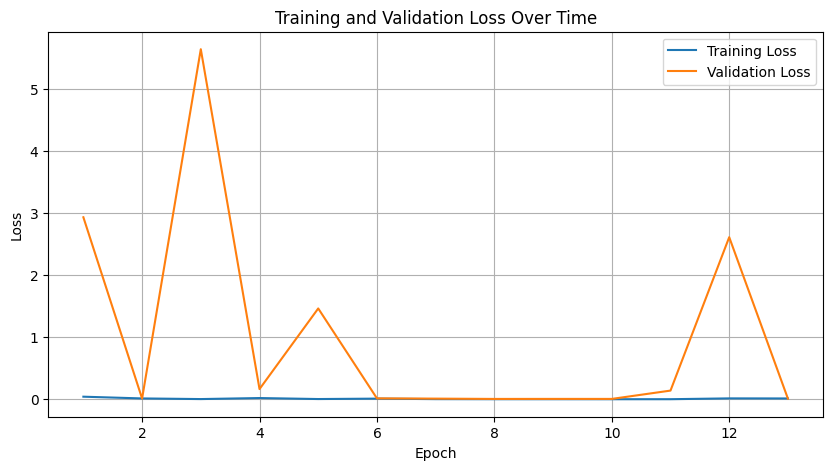

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Put model in evaluation mode
model.eval()

# Store all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())


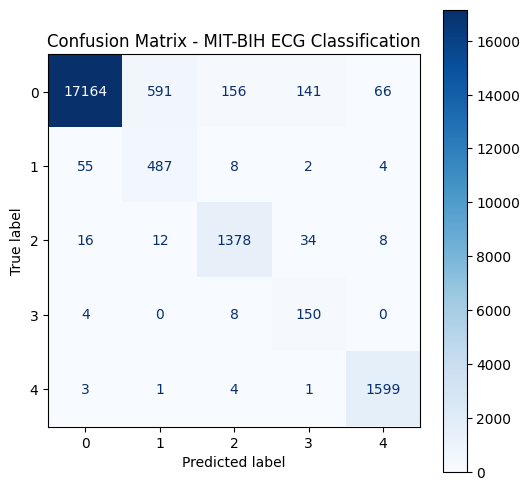

In [19]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - MIT-BIH ECG Classification")
plt.show()


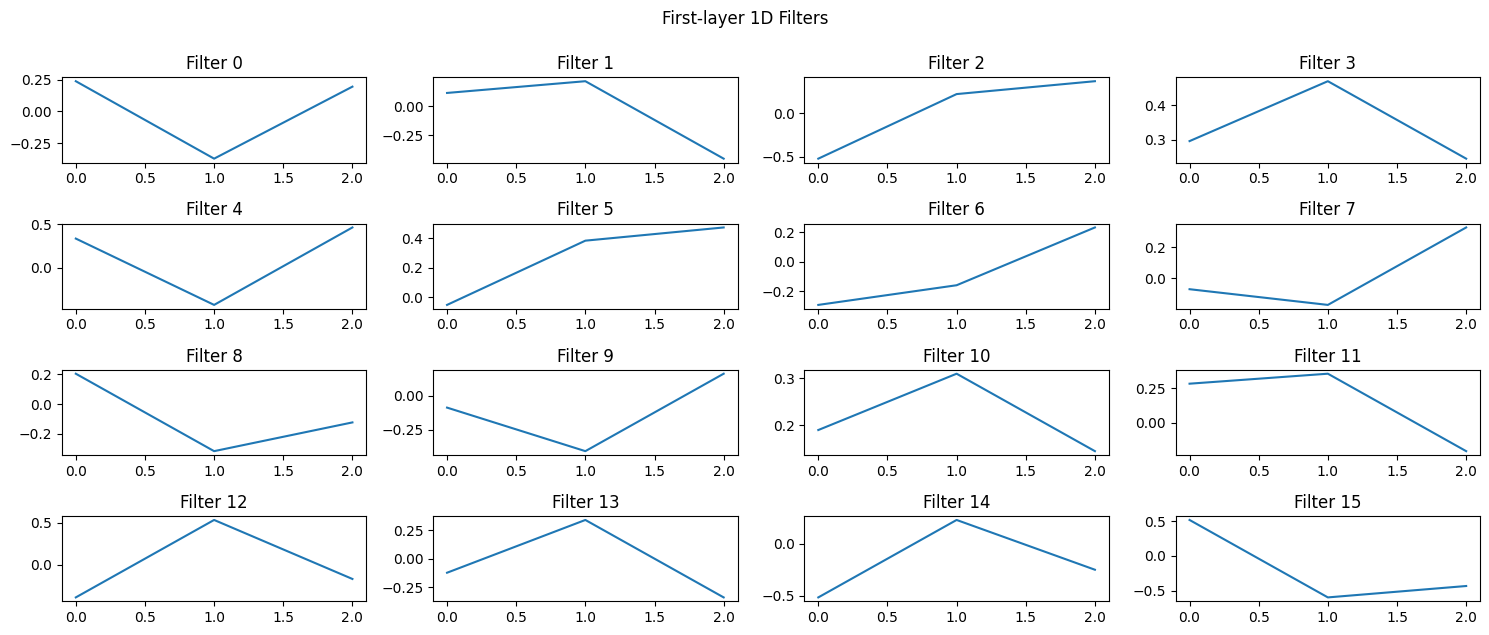

In [20]:
# Print Kernels
first_conv = model.block1.conv1.weight.data.cpu().numpy()  # shape: [out_channels, in_channels, kernel_size]

plt.figure(figsize=(15, 6))
for i in range(min(16, first_conv.shape[0])):  # visualize up to 16 filters
    plt.subplot(4, 4, i+1)
    plt.plot(first_conv[i][0])
    plt.title(f'Filter {i}')
    plt.tight_layout()
plt.suptitle("First-layer 1D Filters", y=1.05)
plt.show()
